# CLASSIFICATION

In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Part1: Data preparation

In [8]:
# Read the data from the file
# Data from https://www.kaggle.com/mirichoi0218/insurance
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/1ekMKZgxX1EuAXnos-6CvX_W3C9jH1VKPgJ4dsb6iuU4/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df = pd.read_excel('sheet.xlsx')

In [9]:
# Check the first few lines to see the column names and type of content
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
# Let us check the types of the different columns
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [11]:
# Let us convert sex, smoker and region to categorical
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df['region'] = df['region'].astype('category')

## Part 2: Data exploration

In [12]:
# Lets see the summary of the numerical columns
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


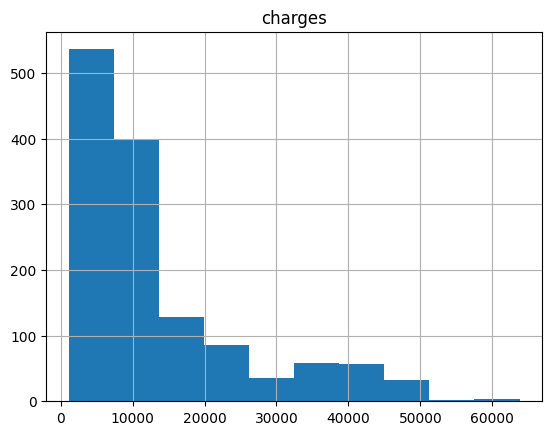

In [13]:
# Histogram of charges
df.hist(column="charges");

<ipython-input-14-f9cfd1924ac3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['charges'].hist(by=df['sex'])


array([<Axes: title={'center': 'female'}>,
       <Axes: title={'center': 'male'}>], dtype=object)

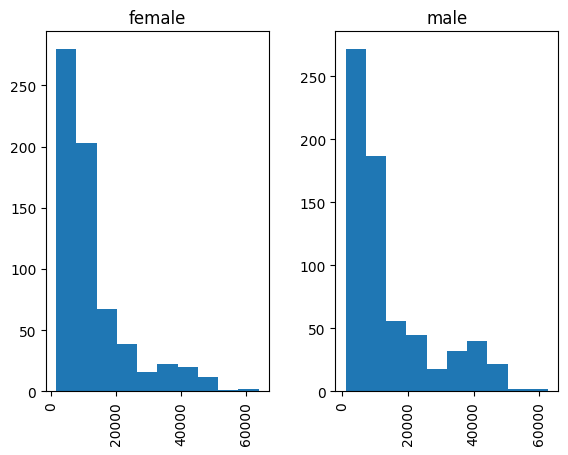

In [14]:
# Check if there are differences by sex
df['charges'].hist(by=df['sex'])

In [15]:
# Check the number of data in the different categories
df['sex'].value_counts()

,count
sex,
male,676
female,662


In [16]:
df['smoker'].value_counts()

,count
smoker,
no,1064
yes,274


In [17]:
df['region'].value_counts()

,count
region,
southeast,364
northwest,325
southwest,325
northeast,324


In [18]:
# Check now some combinations
contingency=pd.crosstab(df["sex"],df["smoker"])
print(contingency)

smoker   no  yes
sex             
female  547  115
male    517  159


In [19]:
# Check if sex and smoking are independent. If the p-value is smaller than 0.05, they are not
c, p, dof, expected = scipy.stats.chi2_contingency(contingency)
print('p-value=%f'%p)

p-value=0.006548


## Classification

We want to determine if there is a relationship between any of these variables and the fact of being in the upper quarter of the insurance price. For doing this, we will construct a new variable with a binary response of being in the upper quarter or not.

In [20]:
df['upperQuarter']=df['charges']>np.quantile(df['charges'],0.75)
df.head()

,age,sex,bmi,children,smoker,region,charges,upperQuarter
0,19,female,27.900,0,yes,southwest,16884.92400,True
1,18,male,33.770,1,no,southeast,1725.55230,False
2,28,male,33.000,3,no,southeast,4449.46200,False
3,33,male,22.705,0,no,northwest,21984.47061,True
4,32,male,28.880,0,no,northwest,3866.85520,False


In [21]:
# Check if there is any relationship between being in the upper quarter and the rest of variables
c, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df['upperQuarter'],df['sex']))
print('p-value upperQuarter vs sex=%f'%p)

c, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df['upperQuarter'],df['smoker']))
print('p-value upperQuarter vs smoker=%f'%p)

c, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df['upperQuarter'],df['region']))
print('p-value upperQuarter vs region=%f'%p)

p-value upperQuarter vs sex=0.021274
p-value upperQuarter vs smoker=0.000000
p-value upperQuarter vs region=0.013706


<Axes: xlabel='upperQuarter', ylabel='age'>

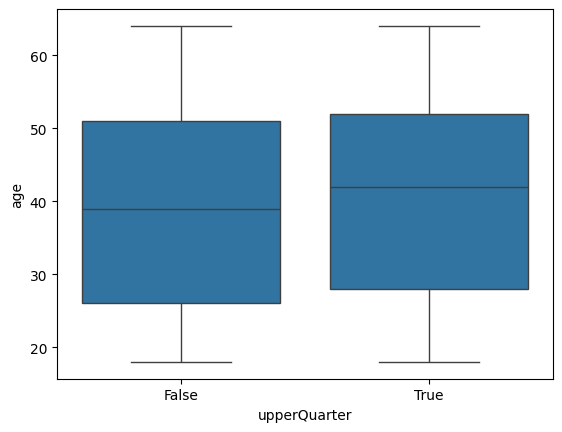

In [22]:
# Now with the numerical variables
sns.boxplot(x='upperQuarter', y='age', data=df)

<Axes: xlabel='upperQuarter', ylabel='bmi'>

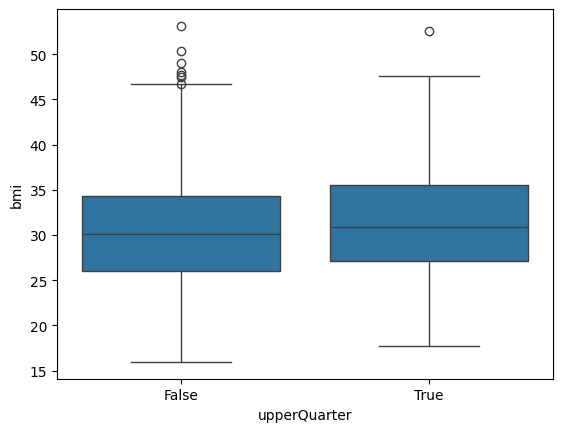

In [23]:
sns.boxplot(x='upperQuarter', y='bmi', data=df)

<Axes: xlabel='upperQuarter', ylabel='children'>

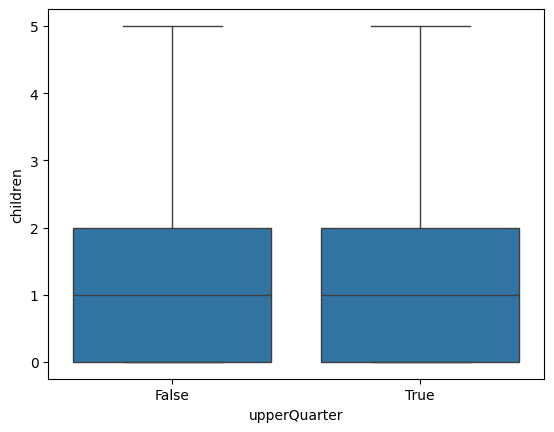

In [24]:
sns.boxplot(x='upperQuarter', y='children', data=df)

## Classification tree

In [25]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
X = df[['age','sex','bmi','children','smoker','region']]
y = df['upperQuarter']

A classification is a problem of the form y=f(X) where y is categorical and X is whatever

In [26]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [27]:
y.head()

,upperQuarter
0,True
1,False
2,False
3,True
4,False


The implementation of the classification tree in sklearn only deals with numerical variables, then we need to convert categorical to numerical variables.

In [28]:
X=pd.get_dummies(X)
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,True,False,False,True,False,False,False,True
1,18,33.770,1,False,True,True,False,False,False,True,False
2,28,33.000,3,False,True,True,False,False,False,True,False
3,33,22.705,0,False,True,True,False,False,True,False,False
4,32,28.880,0,False,True,True,False,False,True,False,False


In [29]:
clf = clf.fit(X,y)
df_feature_names = list(X.columns)
df_target_names = [str(s) for s in y.unique()]

In [30]:
# Let's evaluate the tree
from sklearn import metrics
y_pred = clf.predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.9992526158445441


Let's visualize the tree

In [31]:
print(tree.export_text(clf, feature_names=df_feature_names))

|--- smoker_yes <= 0.50
|   |--- age <= 46.50
|   |   |--- region_northeast <= 0.50
|   |   |   |--- bmi <= 27.23
|   |   |   |   |--- bmi <= 23.65
|   |   |   |   |   |--- bmi <= 23.62
|   |   |   |   |   |   |--- bmi <= 22.66
|   |   |   |   |   |   |   |--- bmi <= 19.10
|   |   |   |   |   |   |   |   |--- bmi <= 18.66
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- bmi >  18.66
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- bmi >  19.10
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- bmi >  22.66
|   |   |   |   |   |   |   |--- bmi <= 22.90
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- bmi >  22.90
|   |   |   |   |   |   |   |   |--- sex_female <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- sex_female >  0.50
|   |   |   |   |   |   |   |   |   |--- children <= 0.50
|   |   |   |   

It is a too complicated tree, let's see if we can construct a simpler tree with similar performance

In [32]:
print('Current depth of the tree=%d'%clf.tree_.max_depth)

Current depth of the tree=17


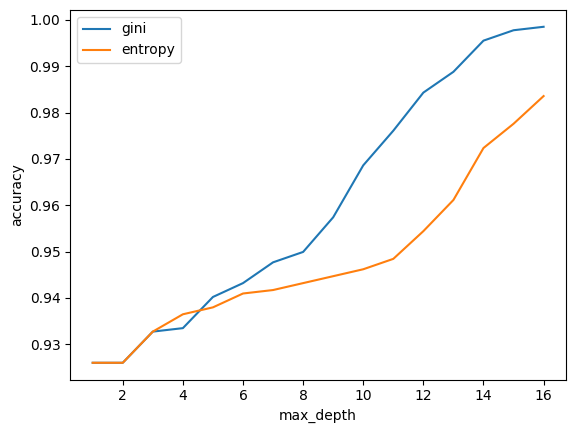

In [33]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,17):
    clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    acc_gini.append(metrics.accuracy_score(y, y_pred))

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    acc_entropy.append(metrics.accuracy_score(y, y_pred))

    max_depth.append(i)

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

With a maximum depth of 2 we already have quite a good classification accuracy (over 93%). For larger depths, Gini splits seem to be better than entropy splits.

In [34]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf.fit(X, y)
y_pred = clf.predict(X)
print('Accuracy with max_depth=%d is %f'%(2,metrics.accuracy_score(y,y_pred)))

Accuracy with max_depth=2 is 0.926009


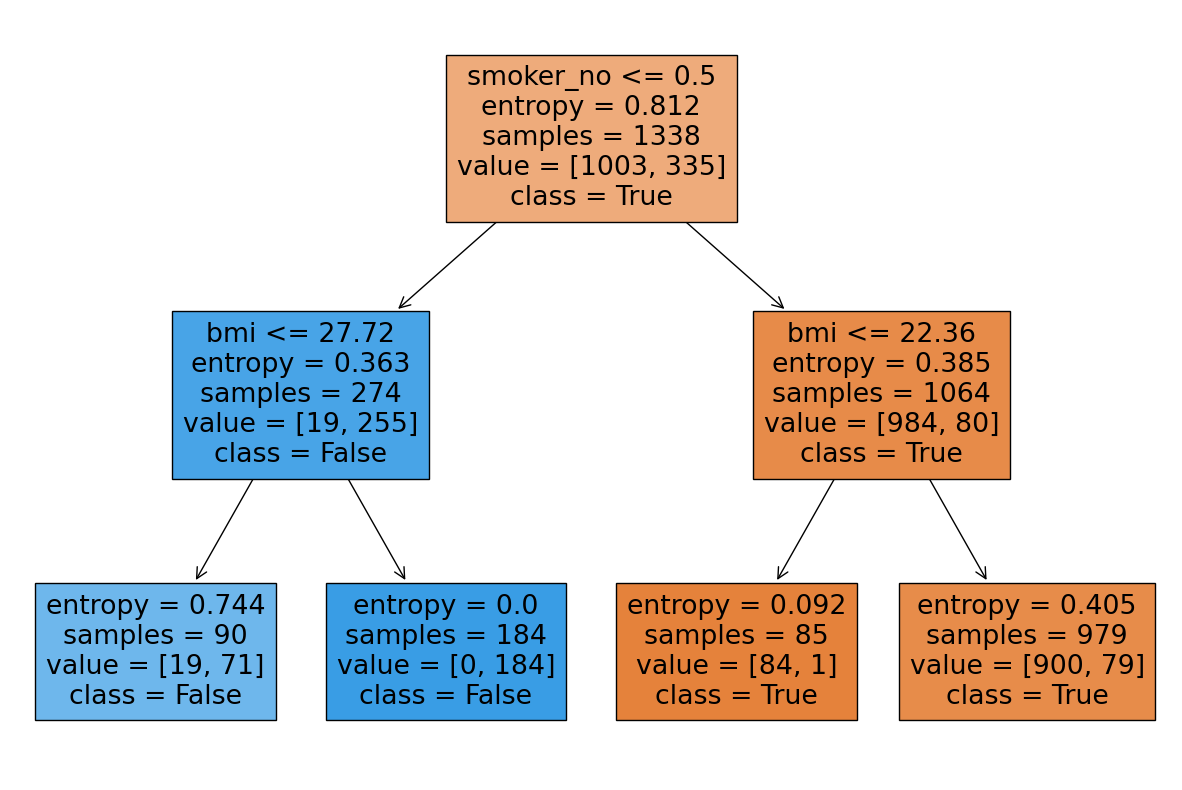

In [35]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf,
                   feature_names=df_feature_names,
                   class_names=df_target_names,
                   filled=True)

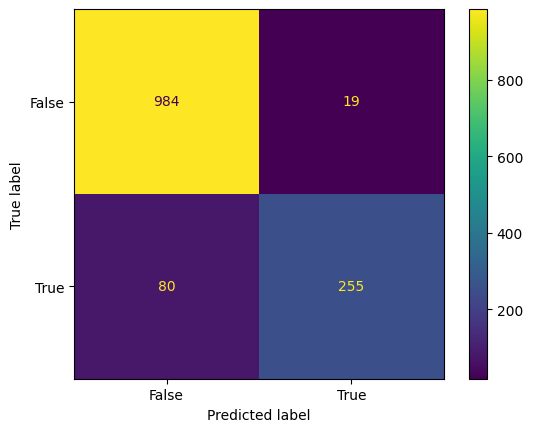

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X, y)

## Extremely simple classifier

We note that the last level of the tree above is not really separating anything (both labels in the split are equal). Then, we may further prune the tree.

In [37]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf.fit(X, y)
y_pred = clf.predict(X)
print('Accuracy with max_depth=%d is %f'%(1,metrics.accuracy_score(y,y_pred)))

Accuracy with max_depth=1 is 0.926009


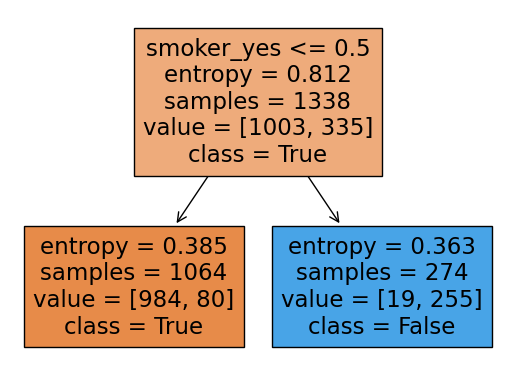

In [38]:
_ = tree.plot_tree(clf,
                   feature_names=df_feature_names,
                   class_names=df_target_names,
                   filled=True)

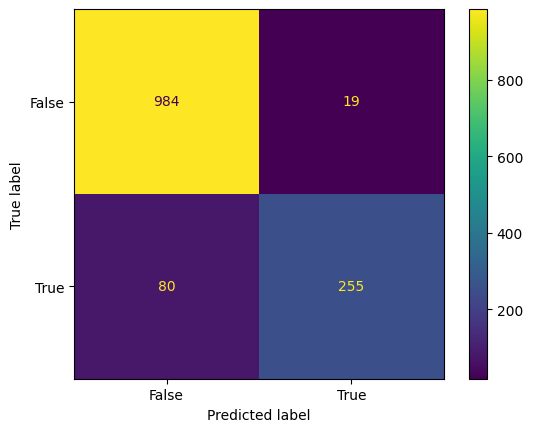

In [39]:
ConfusionMatrixDisplay.from_estimator(clf, X, y)